## EDA

#### Recall（再現率）
- 実際に正例（1着）であるもののうち、モデルが正しく1着と判定できた割合
- $\text{Recall} = \frac{TP}{TP + FN}$
- 1着をどれだけ見逃さずに拾えているか
 
#### Precision（適合率）
- モデルが1着と予測したもののうち、実際に1着だった割合
- $\text{Precision} = \frac{TP}{TP + FP}$
- 予測した1着の「当たりやすさ」
 
#### Accuracy（正解率）
- 全体のうち、正しく予測できた割合
- $\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$
- 全体的な当たりやすさ（不均衡データでは過信禁物）
 
#### 用語
- TP: True Positive（実際1着・予測も1着）
- TN: True Negative（実際1着でない・予測も1着でない）
- FP: False Positive（実際1着でないのに1着と予測）
- FN: False Negative（実際1着なのに1着と予測できず）

#### 必要なライブラリを追加

In [1]:
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import shap

/Users/naozumi/Desktop/WorkSpace/keiba_ai_app/app/keiba_science/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### データの取得

In [ ]:
# BigQueryクライアントを作成する
client = bigquery.Client()

# 取得するデータの範囲を指定する
years = [2023, 2024, 2025]
place_ids = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10"]

# クエリを作成する
query = ""
for year in years:
    for place_id in place_ids:
        if place_id != "01":
            query += " UNION ALL "
        query += f"""
        SELECT *
        FROM `keiba-ai-487108.datalake.race_result_{year}_{place_id}`
        """

# クエリを実行してデータを取得する
df = client.query(query).to_dataframe()

/Users/naozumi/Desktop/WorkSpace/keiba_ai_app/app/keiba_science/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


#### 着順と何が相関あるか見たい

着順との相関係数
着順      1.000000
人気      0.580726
オッズ     0.446615
上がり     0.213225
馬番      0.085894
齢       0.065898
体重変化   -0.015850
体重     -0.070114
斤量     -0.092843
Name: 着順, dtype: float64


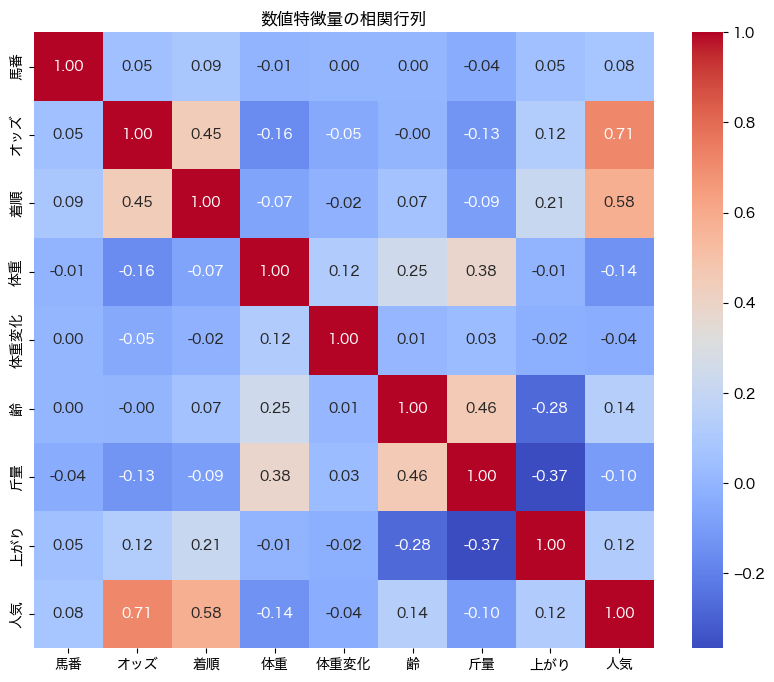

In [3]:
# 主要なカラムを数値型に変換してから相関を計算（日本語フォント対応）

matplotlib.rcParams['font.family'] = 'Hiragino Sans'  # macOS標準日本語フォント

# 数値にしたいカラム名をリストで指定
num_cols = ['着順', 'オッズ', '体重', '体重変化', '斤量', '上がり', '馬番', '齢', '人気']
for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 数値型のカラムのみ抽出
numeric_cols = df.select_dtypes(include='number').columns

# '着順'カラムが存在することを確認
if '着順' in df.columns:
    target_col = '着順'
    # 相関行列を計算
    corr = df[numeric_cols].corr()[target_col].sort_values(ascending=False)
    print('着順との相関係数')
    print(corr)
    # ヒートマップで可視化
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[numeric_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('数値特徴量の相関行列')
    plt.show()
else:
    print("'着順'カラムが見つかりません。カラム名を確認してください。")

#### ベースとなるもでるをlight gbmで作ってみる

In [4]:
# 単勝ラベル（1着予測用）を作成
df['単勝ラベル'] = (df['着順'] == 1).astype(int)
df[['着順', '単勝ラベル']].head()

,着順,単勝ラベル
0,7.0,0
1,1.0,1
2,6.0,0
3,9.0,0
4,2.0,0


[LightGBM] [Info] Number of positive: 2789, number of negative: 35348
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 500
[LightGBM] [Info] Number of data points in the train set: 38137, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
AUC: 0.835
F1: 0.287
Accuracy: 0.732
Precision: 0.177
Recall: 0.769
--- Confusion Matrix ---
[[6464 2401]
 [ 155  515]]
--- Classification Report ---
              precision    recall  f1-score   support

           0      0.977     0.729     0.835      8865
           1      0.177     0.769     0.287       670

    accuracy                          0.732      9535
   macro avg      0.577     0.749     0.561      9535
weighted avg      0.920     0.732     0.796      9535



/Users/naozumi/Desktop/WorkSpace/keiba_ai_app/app/keiba_science/.venv/lib/python3.13/site-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


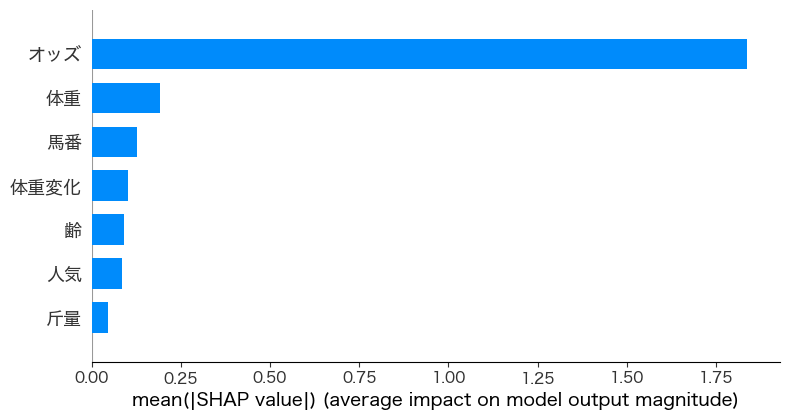

In [32]:
# クラス重み付け（class_weight='balanced'）でLightGBMを再学習 + F1値などの評価指標を追加
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
features = ['オッズ', '体重', '斤量', '人気', '馬番', '体重変化', '齢']
X = df[features]
y = df['単勝ラベル']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = lgb.LGBMClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

pred_proba = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

auc = roc_auc_score(y_test, pred_proba)
f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'AUC: {auc:.3f}')
print(f'F1: {f1:.3f}')
print(f'Accuracy: {acc:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print('--- Confusion Matrix ---')
print(confusion_matrix(y_test, y_pred))
print('--- Classification Report ---')
print(classification_report(y_test, y_pred, digits=3))

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

In [39]:
# 過去10レースで単勝に100円ずつ賭けていた場合のシミュレーション
bet_amount = 100
num_races = 10
num_horses_per_race = 10  # 仮定：1レース10頭
sample = X_test.copy().iloc[:num_races * num_horses_per_race].copy()
sample['予測ラベル'] = model.predict(sample[features])
sample['実際ラベル'] = y_test.iloc[:num_races * num_horses_per_race].values
sample['オッズ'] = df.loc[sample.index, 'オッズ'].values
sample['払戻'] = 0
sample.loc[(sample['予測ラベル'] == 1) & (sample['実際ラベル'] == 1), '払戻'] = sample['オッズ'] * bet_amount
sample['投資'] = bet_amount
total_bet = sample['投資'].sum()
total_return = sample['払戻'].sum()
roi = total_return / total_bet if total_bet > 0 else 0
print(f'投資額: {total_bet:.0f}円')
print(f'払戻額: {total_return:.0f}円')
print(f'回収率(ROI): {roi*100:.1f}%')
display_cols = features + ['オッズ', '予測ラベル', '実際ラベル', '払戻']
display(sample[display_cols])

投資額: 10000円
払戻額: 1930円
回収率(ROI): 19.3%


,オッズ,体重,斤量,人気,馬番,体重変化,齢,オッズ,予測ラベル,実際ラベル,払戻
42305,8.9,496.0,58.0,5.0,12,8.0,5,8.9,1,0,0
38456,16.8,488.0,53.0,6.0,7,10.0,3,16.8,0,0,0
15951,8.1,534.0,56.0,4.0,13,4.0,3,8.1,0,0,0
46829,5.3,442.0,54.0,2.0,2,0.0,3,5.3,1,1,530
37205,5.8,512.0,54.0,5.0,8,4.0,4,5.8,1,1,580
...,...,...,...,...,...,...,...,...,...,...,...
33353,72.8,428.0,56.0,11.0,10,-2.0,2,72.8,0,0,0
23455,267.3,438.0,56.0,16.0,1,0.0,4,267.3,0,0,0
26933,54.4,494.0,56.0,9.0,11,-4.0,3,54.4,0,0,0
2561,4.7,510.0,60.0,3.0,11,0.0,7,4.7,1,0,0


In [43]:
sample[sample['予測ラベル'] == 1][display_cols]

,オッズ,体重,斤量,人気,馬番,体重変化,齢,オッズ,予測ラベル,実際ラベル,払戻
42305,8.9,496.0,58.0,5.0,12,8.0,5,8.9,1,0,0
46829,5.3,442.0,54.0,2.0,2,0.0,3,5.3,1,1,530
37205,5.8,512.0,54.0,5.0,8,4.0,4,5.8,1,1,580
6340,2.4,432.0,54.0,1.0,15,-4.0,3,2.4,1,1,240
20292,3.3,466.0,58.0,1.0,1,4.0,4,3.3,1,0,0
23018,3.3,504.0,54.0,2.0,8,-4.0,3,3.3,1,0,0
4678,7.5,430.0,52.0,5.0,5,0.0,3,7.5,1,0,0
35478,7.4,472.0,55.0,2.0,12,0.0,3,7.4,1,0,0
34070,5.1,470.0,53.0,3.0,6,4.0,2,5.1,1,0,0
39005,12.1,446.0,56.0,7.0,2,-10.0,3,12.1,1,0,0
